# Identify Fraud from Enron Email by Yuan Zhou

## Background

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project, my goal is to play detective, and use my new machine learning skills by building a person of interest(POI) identifier based on financial and email data made public as a result of the Enron scandal based on the assumption that POIs were involved in fraud for high probalitity. The process of this project is going through as what summaried in the course, starting with the dataset exploration, the features are extracted to feed into several machine learning algorithm which will be tuned for final validation and evaluation.

## Dataset Understanding

In [1]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>

In [2]:
import pickle
import sys
sys.path.append("../tools/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from sklearn import cross_validation
from sklearn.feature_selection import SelectKBest, f_classif# Perform feature selection

/anaconda/envs/DataA/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


To explore the dataset in a more convenient way, the dasaset is converted to dataframe. The first 5 data points are list below

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

enron_data = pd.DataFrame.from_dict(data_dict, orient = 'index')

In [4]:
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [5]:
print "Total number of data points : ", len(enron_data.index)
print "Total number of features : ", len(enron_data.columns)

Total number of data points :  146
Total number of features :  21


The dataset is consist of 146 data points, and for each point, it has 21 features, including 14 financial features, 6 e-mail features and 1 POI label. 

The missing value are denoted as "NaN". As shown in the summary table of each feature value below, we found that there are a lot missing vaules for almost every feature except __poi__.

In [6]:
enron_data.describe().transpose()

,count,unique,top,freq
salary,146,95,NaN,51
to_messages,146,87,NaN,60
deferral_payments,146,40,NaN,107
total_payments,146,126,NaN,21
exercised_stock_options,146,102,NaN,44
bonus,146,42,NaN,64
restricted_stock,146,98,NaN,36
shared_receipt_with_poi,146,84,NaN,60
restricted_stock_deferred,146,19,NaN,128
total_stock_value,146,125,NaN,20


Table below lists the data points with more than 15 features are value-missed. We can notice that __LOCKHART EUGENE E__ is a non POI who lost all other features' value and also __THE TRAVEL AGENCY IN THE PARK__ is not an Employee name which may be an unrelated data.

In [7]:
enron_data = enron_data.replace('NaN', np.nan)
NaN = pd.DataFrame(enron_data.shape[1] - enron_data.count(axis=1), columns=['No_NaN'])
NaN.query('No_NaN>15')

,No_NaN
BLAKE JR. NORMAN P,16
CHAN RONNIE,16
CHRISTODOULOU DIOMEDES,16
CLINE KENNETH W,17
FUGH JOHN L,16
GATHMANN WILLIAM D,16
GILLIS JOHN,17
GRAMM WENDY L,18
LOCKHART EUGENE E,20
LOWRY CHARLES P,16


### POI

In [8]:
num_POI = enron_data['poi'].value_counts()[True]
num_nonPOI = enron_data['poi'].value_counts()[False]

print "Total number of POIs in the dataset : ", num_POI
print "Total number of non POIs in the dataset : ", num_nonPOI

print('POIs and non POIs ratio : %.2f and %.2f'  % (float(num_POI)/len(enron_data.index), 
                                                    float(num_nonPOI)/len(enron_data.index)))

Total number of POIs in the dataset :  18
Total number of non POIs in the dataset :  128
POIs and non POIs ratio : 0.12 and 0.88


### Outliers

As analysed above, there are two data points can be seen as outliers.
1. LOCKHART EUGENE E -- no feature values
2. THE TRAVEL AGENCY IN THE PARK -- not an employee name

There are also one big outlier we already found during mini project of using a regression to predict the bonuses for Enron employees as shown in the scatter plot below. The data point named __"TOTAL"__ should be removed, which clearly demonstrated that visualization is one of the most powerful tools for finding outliers! 

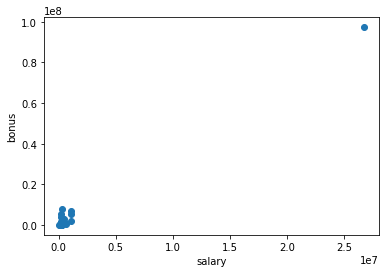

In [9]:
enron_data = enron_data.drop("LOCKHART EUGENE E")
enron_data = enron_data.drop("THE TRAVEL AGENCY IN THE PARK")

_ = plt.scatter(enron_data.salary, enron_data.bonus )
_ = plt.xlabel("salary")
_ = plt.ylabel("bonus")
plt.show()

After removing the biggest outlier, as shown below there are still few more, but we found they are "LAY KENNETH L" and "SKILLING JEFFREY K", two of Enron's biggest bosses, and definitely people of interest. So we should keep these two.

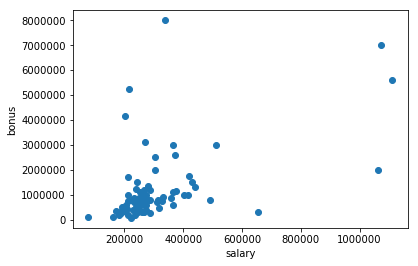

In [10]:
enron_data = enron_data.drop("TOTAL")

_ = plt.scatter(enron_data.salary, enron_data.bonus )
_ = plt.xlabel("salary")
_ = plt.ylabel("bonus")
plt.show()

## Optimize Feature Selection/Engineering

### Create New Features

I have created two new features as discussed in mini-project using our ituition, that the fraction of receiving emails from POIs and sendinng emails to POIs would be essential to differentiate POI and non-POI.
1. __fraction_from_poi_to_this_person__

from_poi_to_this_person / to_messages

2. __fraction_from_this_person_to_poi__

from_this_person_to_poi / from_messages

In [11]:
#replace NaN to 0
enron_data = enron_data.fillna(0)

#1 new feature 'ratio_from_poi_to_this_person'
enron_data['fraction_from_poi_to_this_person'] = enron_data["from_poi_to_this_person"].\
divide(enron_data["to_messages"], fill_value = 0).fillna(0)

#2 new feature 
enron_data['fraction_from_this_person_to_poi'] = enron_data["from_this_person_to_poi"].\
divide(enron_data["from_messages"], fill_value = 0).fillna(0)

#3 remove feature 'email_address'
enron_data = enron_data.drop(columns=['email_address'])

### Feature Seletion

The feature_list includes the two new features and 'email_address' is removed which is not helpful for identifying POI.

feature_list = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'ratio_from_poi_to_this_person','ratio_from_this_person_to_poi']  

In [12]:
data_dict = enron_data.to_dict('index')
feature_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                'director_fees', 'to_messages', 'from_poi_to_this_person', 
                'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 
                'fraction_from_poi_to_this_person','fraction_from_this_person_to_poi']

In [13]:
print "Number of features : ", (len(feature_list)-1)

Number of features :  21


In this project, I performed __SelectKBest__ to select K features according to the k highest scores. In default `k = 10`, in the below table we can see the ranking scores of all features and noticed that top 10 has scores larger than 2. As for how to select __k__, which can be seen as a parameter for tuning. In this project I just use this 10 best features and leave it as a future work.

In [14]:
data = featureFormat(data_dict, feature_list)
labels, features = targetFeatureSplit(data)

selector = SelectKBest(f_classif)
_ = selector.fit(features, labels)
# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
feature_score = pd.DataFrame({'feature':feature_list[1:], 'score':scores})
feature_score.sort_values(by=['score'], ascending=False)

,feature,score
9,exercised_stock_options,5.740357
7,total_stock_value,5.619009
4,bonus,4.958095
0,salary,4.458636
20,fraction_from_this_person_to_poi,4.076292
6,deferred_income,3.035252
11,long_term_incentive,2.700235
12,restricted_stock,2.543209
2,total_payments,2.444987
18,shared_receipt_with_poi,2.403865


From this table, we can notice few things.
1. The first two features are all related with stock, and __exercised_stock_options__ is part of __	total_stock_value__, after learning more about stock options, I would agree that __exercised_stock_options__ is an important indication for POI.
>Exercising a stock option means purchasing the shares of stock per the stock option agreement. The benefit of the option to the option holder comes when the grant price is lower than the market value of the stock at the time the option is exercised. 

2. As we explored in Regression Mini-project, bonus is positively related with salary with few outliers which are POIs, I would keep these two features for further analysis.

3. The new feature __ratio_from_this_person_to_poi__ plays an important role.

In [15]:
featureK = feature_score.loc[feature_score['score'] > 2, 'feature'].tolist()
print "Remaining features: \n", featureK

Remaining features: 
['salary', 'total_payments', 'loan_advances', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'shared_receipt_with_poi', 'fraction_from_this_person_to_poi']


Apart from using SelectKBest to reduce the dimension of features,  for algorithm that supports getting the feature importances like decision tree, we can sort their feature importances to select features. Let's take decision tree as an example, of which `test_size` is set to 0.4 for validation and `random_state` to 42.

In [16]:
from sklearn.tree import DecisionTreeClassifier
## split dataset for training and testing
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split\
                (features, labels, test_size=0.4, random_state=42)

clf = DecisionTreeClassifier(min_samples_split = 40)
_ = clf.fit(features_train,labels_train)
print "Accuracy : ", clf.score(features_test, labels_test)
print "\n"

for num, value in enumerate(clf.feature_importances_):
    if value > 0.1:
        print "feature : ", feature_list[num+1]
        print "importance : ", value
        print "\n"

Accuracy :  0.862068965517


feature :  salary
importance :  0.19195047965


feature :  exercised_stock_options
importance :  0.469097977567


feature :  fraction_from_poi_to_this_person
importance :  0.273381258934




Only three features remained : ['salary', 'exercised_stock_options', 'fraction_from_this_person_to_poi']

### Feature Scaling

To identify POI is a classification(discrete) problem, we can choose different algorithms to work with. However, several algorithms may be affected by feature scaling, such as _SVM_ and _linear regression_, so for specific algorithm, we can apply _MinMaxScaler_ to scale the features.

## Pick and Tune an Algorithm

### Algorithm Tunning

Bias-variance tradeoff is one of the key dilema in machine learning. High bias algorithms has no capacity to learn, high variance algorithms react poorly in case they didn't see such data before. Predictive model should be tuned to achieve compromise. The process of changing the parameteres of algorithms is algorithm tuning and it lets us find the golden mean and best result. If I don't tune the algorithm well, I don't get the best result I could.

Algorithm might be tuned manually by iteratively changing the parameteres and tracking the results. Or GridSearchCV might be used which makes this automatically.

Three different algorithms for classification are performed and the parameters are tuned using GridSearchCV, including Naive Bayes, SVM, and Decision Tree, of which only SVM requires feature scaling. For each algorithm, the parameters need to be tuned are listed below.

- GaussianNB: NaN
- SVC: `C`, `gamma`
- DecisionTreeClassifier: `min_samples_split`, `min_samples_leaf`

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

Below are the tunning and accuracy results, __10-folds__ cross validation is applied for validation since I found that randomly splitting dataset has a great influence on the results. , labels=np.unique(y_pred)

In [18]:
def kfold_cv(cv_clf, X, y, n_splits=10, apply_PCA=False, apply_scale = False):
    cv = KFold(n_splits=n_splits)
    accuracy = []
    precision = []
    recall = []
    F1 = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]        
        if apply_scale:
            scaler = MinMaxScaler()
            _ = scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        if apply_PCA:
            pca = PCA(n_components=3)
            _ = pca.fit(X_train)
            #transform
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)

        cv_clf.fit(X_train, y_train)
        y_pred = cv_clf.predict(X_test)
        
        accuracy.append(cv_clf.score(X_test, y_test))
        precision.append(precision_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        recall.append(recall_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        F1.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
#     print "accuracy : ", accuracy
#     print "precision:", precision
#     print "recall : ", recall
#     print "F1:", F1
                    
    evaluation = pd.DataFrame({"accuracy" : [sum(accuracy)/float(len(accuracy))],
                               "precision" :[sum(precision)/float(len(precision))],
                               "recall" : [sum(recall)/float(len(recall))],
                               "F1 score" : [sum(F1)/float(len(F1))]})
    
    return evaluation

#### (1) GaussianNB

For GaussianNB, I performed the following steps.
- Using __SelectKBest__ to select 11 features with scores greater than 2.
- Split dataset into train/test
- Applying __PCA__ to train set reducing the dimensionality to 3 and applied the same transform to both train and test set.
- K-fold cross evaluation

In [19]:
#feature list after SelectKBest
feature_listK =  ['poi'] + featureK

#split into train and test using kfold
data_K = featureFormat(data_dict, feature_listK)
labels_K, features_K = targetFeatureSplit(data_K)

# classifier
clf_GNB = GaussianNB()

evaluation_GNB = kfold_cv(clf_GNB, features_K, labels_K, apply_PCA=True)

/anaconda/envs/DataA/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda/envs/DataA/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
evaluation_GNB

,F1 score,accuracy,precision,recall
0,0.790441,0.866667,0.785082,0.834524


#### (2) SVC

For SVC, I performed the following steps.
- Using __SelectKBest__ to select 11 features with scores greater than 2.
- Split dataset into train/test
- Perform __MinMaxScaler__ to scale the features
- Applying __PCA__ to train set reducing the dimensionality to 3 and applied the same transform to both train and test set.

(above are exactly same as GaussianNB)
- Using __GridSearchCV__ to get the optimal parameters.
- K-fold cross evaluation

Below are the optimal parameters value achieved after performing the parameters tuning.

In [21]:
#split the dataset into train/test
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split\
                (features_K, labels_K, test_size=0.4, random_state=42)
#feature scaling
scaler = MinMaxScaler()
_ = scaler.fit(features_train)
features_train_scale = scaler.transform(features_train)
features_test_scale = scaler.transform(features_test)

#pca fit on train set
pca = PCA(n_components=3)
_ = pca.fit(features_train_scale)
#transform
features_train_pca = pca.transform(features_train_scale)
features_test_pca = pca.transform(features_test_scale)

In [22]:
param_grid = {
       'C': [1, 10, 1e2, 5e2, 1e3, 5e3, 1e4],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 0.3],
        }

clf_SVC = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

_ = clf_SVC.fit(features_train_pca, labels_train)

print "Best estimator found by grid search:"
print clf_SVC.best_estimator_

Best estimator found by grid search:
SVC(C=500.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [23]:
evaluation_SVC = kfold_cv(clf_SVC.best_estimator_, features_K, labels_K, apply_PCA=True, apply_scale=True)

In [24]:
evaluation_SVC

,F1 score,accuracy,precision,recall
0,0.674476,0.853333,0.709267,0.693715


#### (3) DecisionTreeClassifier

For DecisionTreeClassifier, I performed the following steps.
- Split dataset into train/test with all features
- Comparing the feature_importance to select features

Which has been done in _Feature Selection_ part

- Using __GridSearchCV__ to get the optimal parameters.
- K-fold cross evaluation

Below are the optimal parameters value achieved after performing the parameters tuning.

In [25]:
feature_importance = ['poi', 'salary', 'exercised_stock_options', 'fraction_from_this_person_to_poi']
# get features and labels
data = featureFormat(data_dict, feature_importance)
labels, features = targetFeatureSplit(data)

#split into train and test
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split\
                (features, labels, test_size=0.4, random_state=42)

param_grid= {'min_samples_split': [2, 4, 8, 16, 32, 64],
             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8]
            }

clf_DT = GridSearchCV(DecisionTreeClassifier(), param_grid)

_ = clf_DT.fit(features_train, labels_train)

print "Best estimator found by grid search:"
print clf_DT.best_estimator_

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [26]:
evaluation_DT = kfold_cv(clf_DT.best_estimator_, features, labels)

In [27]:
evaluation_DT

,F1 score,accuracy,precision,recall
0,0.605587,0.801923,0.613918,0.636886


### Validation and Evaluation

#### Validation

In machine learning, model validation is referred to as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the generalization ability of a trained mode. 

There are a number of strategies to validate the model. One of them is to split the available data into train and test data another one is k-fold cross validation, which splits dataset into k consecutive folds, each fold is then used once as a validation while the (k - 1) remaining folds form the training set.

In this project, I performed 10-folds cross validation, which means for 146 samples in total, the first 6 folds have size 15,  other 4 folds have size 14. Each folds will be used as testing set once while others are training set.



#### Evaluation

Apart from accuracy, there are three more matrices, including Precision, Recall and F1-score are used for evaluation. 

__Accuracy__: Mean accuracy on the given test data and labels, whether the prediction of POI or non-POI is right or not.

__Recall__: True Positive / (True Positive + False Negative). Out of all the items that are truly positive, how many were correctly classified as positive. Or simply, how many positive items were 'recalled' from the dataset.

__Precision__: True Positive / (True Positive + False Positive). Out of all the items labeled as positive, how many truly belong to the positive class.

__F1-score__ : It is a harmonic mean of recall and precision. It is calculated as (2xrecallxprecision)/(recall + precision). It reached its best value at 1 and worse value at 0.

'The performance of the selected three algorithms are shown below

In [28]:
results = pd.concat([evaluation_GNB, evaluation_SVC, evaluation_DT], keys = ['GaussianNB', 'SVC', 'DT'])

In [29]:
results

,,F1 score,accuracy,precision,recall
GaussianNB,0,0.790441,0.866667,0.785082,0.834524
SVC,0,0.674476,0.853333,0.709267,0.693715
DT,0,0.605587,0.801923,0.613918,0.636886


Comparing the metrics, GaussinNB performs best with  the highest scores for all metrics.

## Reference

https://www.upcounsel.com/exercise-stock-options

https://en.wikipedia.org/wiki/Hyperparameter_optimization

https://stackoverflow.com/questions/22903267/what-is-tuning-in-machine-learning
